In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# 1. Data Loading and Preprocessing
def load_and_preprocess_data(filepath):
    """
    Load and preprocess the diabetes dataset
    """
    # Load the data
    print("Loading data...")
    df = pd.read_csv(filepath)

    # Basic info
    print(f"Dataset shape: {df.shape}")

    # Define target variable
    # Convert readmitted to binary classification: >30 and NO to 0, <30 to 1
    df['readmitted'] = df['readmitted'].map({'NO': 0, '>30': 0, '<30': 1})

    # Check class distribution
    print("Class distribution:")
    print(df['readmitted'].value_counts(normalize=True))

    # Handle missing values
    df.replace('?', np.nan, inplace=True)

    # Identify categorical and numerical columns
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    num_cols.remove('readmitted')  # Remove target from numerical columns

    # Feature Engineering

    # Group diagnosis codes
    def map_diagnosis(diag):
        if pd.isna(diag) or diag == '?':
            return 'Unknown'
        try:
            diag_float = float(diag)
            if 390 <= diag_float <= 459 or diag_float == 785:
                return 'Circulatory'
            elif 460 <= diag_float <= 519 or diag_float == 786:
                return 'Respiratory'
            elif 520 <= diag_float <= 579 or diag_float == 787:
                return 'Digestive'
            elif 250 <= diag_float <= 250.99:
                return 'Diabetes'
            elif 800 <= diag_float <= 999:
                return 'Injury'
            elif 710 <= diag_float <= 739:
                return 'Musculoskeletal'
            elif 580 <= diag_float <= 629 or diag_float == 788:
                return 'Genitourinary'
            elif 140 <= diag_float <= 239:
                return 'Neoplasms'
            else:
                return 'Other'
        except:
            return 'Other'

    df['diag_1_group'] = df['diag_1'].apply(map_diagnosis)
    df['diag_2_group'] = df['diag_2'].apply(map_diagnosis)
    df['diag_3_group'] = df['diag_3'].apply(map_diagnosis)

    # Create feature for number of medications
    med_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                  'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                  'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                  'miglitol', 'troglitazone', 'tolazamide', 'examide',
                  'citoglipton', 'insulin', 'glyburide-metformin',
                  'glipizide-metformin', 'glimepiride-pioglitazone',
                  'metformin-rosiglitazone', 'metformin-pioglitazone']

    # Convert medication columns to binary (1 if any medication was given, 0 if not)
    for col in med_columns:
        df[col] = df[col].map({'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1})

    # Calculate total medications count
    df['total_med_taken'] = df[med_columns].sum(axis=1)

    # Age as numerical
    age_map = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
               '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
               '[80-90)': 85, '[90-100)': 95}
    df['age_num'] = df['age'].map(age_map)

    # Add features for medical complexity
    df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
    df['medical_complexity'] = df['num_lab_procedures'] + df['num_procedures']

    # Select final features
    cat_features = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
                   'admission_source_id', 'medical_specialty', 'diag_1_group',
                   'diag_2_group', 'diag_3_group', 'max_glu_serum', 'A1Cresult',
                   'change', 'diabetesMed']

    num_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                   'num_medications', 'number_outpatient', 'number_emergency',
                   'number_inpatient', 'number_diagnoses', 'age_num',
                   'total_med_taken', 'service_utilization', 'medical_complexity']

    # Create X and y
    X = df[cat_features + num_features]
    y = df['readmitted']

    return X, y, cat_features, num_features

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def train_and_evaluate_models(X, y, cat_features, num_features):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])
    
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    results = {}
    trained_models = {}
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'XGBoost': xgb.XGBClassifier(objective='binary:logistic', random_state=42, tree_method='hist', 
                                     scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
    }
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train_processed, y_train)
        y_pred = model.predict(X_test_processed)
        y_prob = model.predict_proba(X_test_processed)[:, 1]
        
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_prob),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred)
        }
        trained_models[name] = model
    
    # Neural Network
    def create_nn_model(input_dim):
        model = Sequential([
            Dense(128, input_dim=input_dim, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
        return model
    
    nn_model = create_nn_model(X_train_processed.shape[1])
    
    early_stopping = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    
    class_weights = {0: 1.0, 1: len(y_train[y_train==0])/len(y_train[y_train==1])}
    
    history = nn_model.fit(X_train_processed, y_train, validation_split=0.2, epochs=50, batch_size=64,
                            class_weight=class_weights, callbacks=[early_stopping, reduce_lr], verbose=1)
    
    y_prob_nn = nn_model.predict(X_test_processed, verbose=0).flatten()
    y_pred_nn = (y_prob_nn > 0.5).astype(int)
    
    results['Neural Network'] = {
        'accuracy': accuracy_score(y_test, y_pred_nn),
        'f1_score': f1_score(y_test, y_pred_nn),
        'roc_auc': roc_auc_score(y_test, y_prob_nn),
        'confusion_matrix': confusion_matrix(y_test, y_pred_nn),
        'classification_report': classification_report(y_test, y_pred_nn)
    }
    trained_models['Neural Network'] = nn_model
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    if 'auc' in history.history:
        plt.plot(history.history['auc'], label='Training AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
    else:
        print("AUC metric not found in history, skipping AUC plot.")
    plt.title('AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


    # Convert results dictionary into DataFrame for better visualization
    results_df = pd.DataFrame.from_dict(results, orient='index')

    # Print results in a tabular format
    print("\nFinal Model Performance Summary:")
    print(results_df[['accuracy', 'f1_score', 'roc_auc']].to_string())
    
    return results, preprocessor, trained_models


Loading data...
Dataset shape: (101766, 47)
Class distribution:
readmitted
0    0.888401
1    0.111599
Name: proportion, dtype: float64

Training Logistic Regression...

Training Decision Tree...

Training Random Forest...

Training XGBoost...
Epoch 1/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5571 - auc: 0.5705 - loss: 1.3109 - val_accuracy: 0.6513 - val_auc: 0.6473 - val_loss: 0.6426 - learning_rate: 0.0010
Epoch 2/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6133 - auc: 0.6468 - loss: 1.1735 - val_accuracy: 0.6179 - val_auc: 0.6628 - val_loss: 0.6465 - learning_rate: 0.0010
Epoch 3/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6158 - auc: 0.6678 - loss: 1.1514 - val_accuracy: 0.6255 - val_auc: 0.6675 - val_loss: 0.6375 - learning_rate: 0.0010
Epoch 4/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6139 - auc: 0.6725 - loss: 1.1451 - val_accuracy: 0.6317 - val_auc: 0.6700 - val_loss: 0.6293 - learning_rate: 0.0010
Epoch 5/50
1

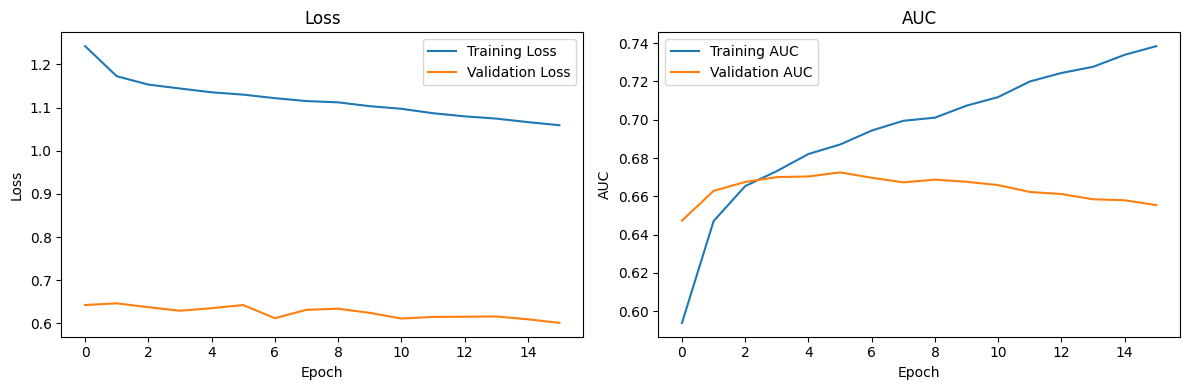


Final Model Performance Summary:
                     accuracy  f1_score   roc_auc
Logistic Regression  0.671072  0.281421  0.684022
Decision Tree        0.804166  0.156937  0.524004
Random Forest        0.888621  0.011339  0.658868
XGBoost              0.680112  0.275992  0.670416
Neural Network       0.619338  0.273852  0.684386


In [16]:
# Train models
data_path = r'D:\DiabetesProject\DiabetesProject\data\preprocessed\diabetes_without_weight_cleaned.csv'

X, y, cat_features, num_features = load_and_preprocess_data(data_path)

results, preprocessor, trained_models = train_and_evaluate_models(X, y, cat_features, num_features)


In [6]:
# Print the best model based on ROC AUC score
best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
print(f"\nBest model: {best_model_name}")



Best model: Neural Network


In [17]:
import joblib
# Save each trained model
for model_name, model in trained_models.items():
    model_filename = f"{model_name.replace(' ', '_')}.pkl"
    joblib.dump(model, model_filename)
    print(f"Saved {model_name} as {model_filename}")

# Save the preprocessor
joblib.dump(preprocessor, "preprocessor.pkl")
print("Saved preprocessor as preprocessor.pkl")


Saved Logistic Regression as Logistic_Regression.pkl
Saved Decision Tree as Decision_Tree.pkl
Saved Random Forest as Random_Forest.pkl
Saved XGBoost as XGBoost.pkl
Saved Neural Network as Neural_Network.pkl
Saved preprocessor as preprocessor.pkl


In [5]:
import numpy as np
import pandas as pd
import random
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Lambda
from tensorflow.keras.optimizers import Adam
import os
import warnings

warnings.filterwarnings('ignore')

# 🚀 Load dataset
cat_features = ['categorical_feature1', 'categorical_feature2']
num_features = ['numerical_feature1', 'numerical_feature2']
target_column = 'readmission'

df = pd.DataFrame({
    'numerical_feature1': np.random.rand(1000),
    'numerical_feature2': np.random.rand(1000),
    'categorical_feature1': np.random.choice(['A', 'B', 'C'], 1000),
    'categorical_feature2': np.random.choice(['X', 'Y', 'Z'], 1000),
    'readmission': np.random.choice([0, 1], 1000)
})

X = df.drop(columns=[target_column])
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🚀 Preprocessing pipeline
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 🚀 Dueling DQN Architecture
def create_dueling_dqn(input_dim, output_dim=2):
    inputs = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # **Dueling network: Separate Value & Advantage streams**
    value = Dense(1, activation='linear')(x)
    advantage = Dense(output_dim, activation='linear')(x)

    q_values = Lambda(lambda a: a[0] + (a[1] - tf.reduce_mean(a[1], axis=1, keepdims=True)))(
        [value, advantage]
    )

    model = tf.keras.Model(inputs, q_values)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# 🚀 Create Model
dqn_model = create_dueling_dqn(X_train_processed.shape[1])

# 🚀 Reward Function (Improved with Patient Severity Impact)
def get_reward(y_true, y_pred):
    if y_true == 1 and y_pred == 1:
        return 10  # Correctly predicted readmission
    elif y_true == 0 and y_pred == 0:
        return 5   # Correctly predicted no readmission
    elif y_true == 1 and y_pred == 0:
        return -15  # High penalty for false negative
    else:
        return -5   # Mild penalty for false positive

# 🚀 Hyperparameters
epsilon, epsilon_min, epsilon_decay = 1.0, 0.01, 0.995
gamma = 0.99  # Higher gamma for long-term reward
batch_size, epochs = 64, 100  # Increased training epochs
target_update_freq = 10  # Update target network every 10 epochs
memory = deque(maxlen=50000)  # Experience replay buffer
target_model = create_dueling_dqn(X_train_processed.shape[1])  # Target network
target_model.set_weights(dqn_model.get_weights())  # Initialize with same weights

# 🚀 Training Loop
for epoch in range(epochs):
    total_reward = 0
    indices = np.arange(X_train_processed.shape[0])
    np.random.shuffle(indices)
    X_shuffled, y_shuffled = X_train_processed[indices], y_train.iloc[indices].values

    for i in range(len(X_shuffled)):
        state = X_shuffled[i:i+1]
        action = np.random.randint(0, 2) if np.random.rand() <= epsilon else np.argmax(dqn_model.predict(state, verbose=0)[0])
        reward = get_reward(y_shuffled[i], action)
        total_reward += reward

        next_state = X_shuffled[i + 1:i + 2] if i + 1 < len(X_shuffled) else state
        memory.append((state, action, reward, next_state, y_shuffled[i]))

        # Train only if we have enough samples
        if len(memory) > batch_size:
            batch = random.sample(memory, batch_size)
            states = np.vstack([exp[0] for exp in batch])
            actions = np.array([exp[1] for exp in batch])
            rewards = np.array([exp[2] for exp in batch])
            next_states = np.vstack([exp[3] for exp in batch])

            # **Double DQN Update**
            q_next_online = dqn_model.predict(next_states, verbose=0)
            q_next_target = target_model.predict(next_states, verbose=0)
            best_actions = np.argmax(q_next_online, axis=1)
            q_targets = rewards + gamma * q_next_target[np.arange(batch_size), best_actions]

            q_values = dqn_model.predict(states, verbose=0)
            q_values[np.arange(batch_size), actions] = q_targets

            dqn_model.train_on_batch(states, q_values)

    # Update Target Model Weights
    if epoch % target_update_freq == 0:
        target_model.set_weights(dqn_model.get_weights())

    # Adaptive Epsilon Decay (Exponential)
    epsilon = max(epsilon * np.exp(-0.01 * epoch), epsilon_min)

    print(f"Epoch {epoch+1}/{epochs}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

# 🚀 Evaluate Model
y_pred_prob = dqn_model.predict(X_test_processed, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"🚀 Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", conf_matrix)



Epoch 1/100, Total Reward: -1260, Epsilon: 1.0000
Epoch 2/100, Total Reward: -935, Epsilon: 0.9900
Epoch 3/100, Total Reward: -1135, Epsilon: 0.9704
Epoch 4/100, Total Reward: -1120, Epsilon: 0.9418
Epoch 5/100, Total Reward: -690, Epsilon: 0.9048
Epoch 6/100, Total Reward: -555, Epsilon: 0.8607
Epoch 7/100, Total Reward: -665, Epsilon: 0.8106
Epoch 8/100, Total Reward: 0, Epsilon: 0.7558
Epoch 9/100, Total Reward: -315, Epsilon: 0.6977
Epoch 10/100, Total Reward: 70, Epsilon: 0.6376
Epoch 11/100, Total Reward: 110, Epsilon: 0.5769
Epoch 12/100, Total Reward: 245, Epsilon: 0.5169
Epoch 13/100, Total Reward: 615, Epsilon: 0.4584
Epoch 14/100, Total Reward: 685, Epsilon: 0.4025
Epoch 15/100, Total Reward: 1175, Epsilon: 0.3499
Epoch 16/100, Total Reward: 1345, Epsilon: 0.3012
Epoch 17/100, Total Reward: 1070, Epsilon: 0.2567
Epoch 18/100, Total Reward: 1610, Epsilon: 0.2165
Epoch 19/100, Total Reward: 1580, Epsilon: 0.1809
Epoch 20/100, Total Reward: 1815, Epsilon: 0.1496
Epoch 21/100, 

In [6]:
# Save the trained model
model_directory = r"D:\DiabetesProject\DiabetesProject\notebooks\models"
os.makedirs(model_directory, exist_ok=True)
dqn_model.save(os.path.join(model_directory, "dqn_model.h5"))

In [7]:
# Model evaluation
q_values = dqn_model.predict(X_test_processed, verbose=0)
y_pred_rl = np.argmax(q_values, axis=1)
accuracy, f1 = accuracy_score(y_test, y_pred_rl), f1_score(y_test, y_pred_rl)
roc_auc = roc_auc_score(y_test, tf.nn.softmax(q_values).numpy()[:, 1])

print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
print(classification_report(y_test, y_pred_rl))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rl))

Accuracy: 0.5200, F1 Score: 0.6471, ROC AUC: 0.4772
              precision    recall  f1-score   support

           0       0.53      0.16      0.25        98
           1       0.52      0.86      0.65       102

    accuracy                           0.52       200
   macro avg       0.53      0.51      0.45       200
weighted avg       0.53      0.52      0.45       200

Confusion Matrix:
[[16 82]
 [14 88]]


In [2]:
import joblib
import numpy as np

# Load the model
model = joblib.load(r"D:\DiabetesProject\DiabetesProject\backend\models\XGBoost.pkl")

# Provide all 177 features (your known values + padding)
features = np.array([65, 45, 12, 2, 1, 1, 1])  # Your known input
features = np.pad(features, (0, 177 - len(features)), 'constant', constant_values=0)  # Pad with 0s

# Make prediction
prediction = model.predict(features.reshape(1, -1))

print("Prediction:", prediction)


Prediction: [0]
